# 0. Librerias y helpers

En esta sección se importan librerias necesarias para el proyecto, así como funciones de ayuda para mostrar información que nos ayude a realizar el análisis y procesado.

In [292]:
%pip install seaborn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [293]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [294]:
#importamos librerias necesarias para todo el proyecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import Lasso, Ridge,LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [295]:
#Definimos funcion para sacar los NA de una columna de un dataframe, junto con su % de NA
def analizar_na_columna(dataframe, columns):
    data = []
    for column in columns:
        total_filas = len(dataframe)
        filas_con_na = dataframe[column].isna().sum()
        porcentaje_con_na = (filas_con_na / total_filas) * 100
        filas_sin_na = total_filas - filas_con_na
        porcentaje_sin_na = (filas_sin_na / total_filas) * 100
        data.append([column,total_filas,filas_con_na,porcentaje_con_na,filas_sin_na,porcentaje_sin_na])    
    print(tabulate(data, headers=['Columna','Total Filas', 'NA','% NA','Sin NA','% Sin NA'], tablefmt='orgtbl'))
    print('\n')

#Funcion propia de describe,que aporta a mayores cual es el valor que define un oulier, cuantos aouliers deja y el porcentaje de outliers(por arriba y por abajo)
def extended_describe(dataframe,columns,ratio=1.5):
    if(dataframe[columns].isna().sum().sum() > 0):
        print('El dataframe tiene NA en las columnas de la variable columns, no se puede usar la funcion')
        return
    data = []
    for column in columns:
        count = dataframe[column].count()
        mean = dataframe[column].mean()
        std = dataframe[column].std()
        min = dataframe[column].min()
        percent25 = dataframe[column].quantile(0.25)
        percent50 = dataframe[column].quantile(0.50)
        percent75 = dataframe[column].quantile(0.75)
        max = dataframe[column].max()
        IQR = percent75 - percent25
        min_outlier = percent25 - (IQR * ratio)
        max_outlier = percent75 + (IQR * ratio)
        total_min_outliers = len(dataframe[dataframe[column] < min_outlier])
        total_max_outliers = len(dataframe[dataframe[column] > max_outlier])
        percent_total_min_outliers = (total_min_outliers / count) * 100
        percent_total_max_outliers = (total_max_outliers / count) * 100
        data.append([column,
                     count,
                     mean,
                     std,
                     min,
                     total_min_outliers,
                     percent_total_min_outliers,
                     min_outlier,
                     percent25,
                     percent50,
                     percent75,
                     max_outlier,
                     total_max_outliers,
                     percent_total_max_outliers,
                     max])
    print(tabulate(data, headers=['Columna','Total','Mean','Std','Min','MinOut Total','MinOut %','MinOut Value','Q1','Q2','Q3','MaxOut Value','MaxOut Total','MaxOut %','Max'], tablefmt='orgtbl'))    



# 1.- Limpieza y preprocesado de datos

In [296]:
#Cargamos el dataset
df_madrid = pd.read_csv('./airbnb-listings-extract.csv', sep=';')

### 1.1.- Columnas de información irrelevante


En este caso borraremos información del siguiente tipo:
- Información sobre el anfitrión, que son las columnas que contienen la palabra "Host"
- Identificador del inmueble y url del inmueble en airnbnb
- Textos libres de descripciones
- Imagenes y urls.
- Datos sobre el scrapping.
- Features
- La fecha en que fue actualizada la ficha del inmueble en airbnb

In [297]:
rowsToDrop = ['ID','Listing Url','Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location','Host About', 'Host Response Time', 'Host Response Rate','Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url','Host Neighbourhood', 'Host Listings Count','Host Total Listings Count', 'Host Verifications','Calculated host listings count','Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview','Notes', 'Transit', 'Access', 'Interaction', 'House Rules','Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url','Scrape ID', 'Last Scraped','Calendar last Scraped','Features','Calendar Updated']
df_madrid = df_madrid.drop(rowsToDrop, axis=1)

### 1.2.- Columnas con mayoria NA


Buscamos columnas con muy pocos valores, como es el caso de:
 - "Square Feet"(14182 NA (96%)) 
 - "Has Availability" (14768 NA (>99%))
 - "License" (14431 NA (98%))
 - "Jurisdiction Names(14553 NA (98%)"

Como se puede ver en las tablas, el porcentaje de NA son mayores al 95%, por lo que automáticamente los descartamos

In [298]:
analizar_na_columna(df_madrid, ['Square Feet','Has Availability','License','Jurisdiction Names'])
rowsToDrop = ['Square Feet','Has Availability','License','Jurisdiction Names']
df_madrid = df_madrid.drop(rowsToDrop, axis=1)


| Columna            |   Total Filas |    NA |    % NA |   Sin NA |   % Sin NA |
|--------------------+---------------+-------+---------+----------+------------|
| Square Feet        |         14780 | 14182 | 95.954  |      598 |  4.04601   |
| Has Availability   |         14780 | 14768 | 99.9188 |       12 |  0.0811908 |
| License            |         14780 | 14431 | 97.6387 |      349 |  2.3613    |
| Jurisdiction Names |         14780 | 14553 | 98.4641 |      227 |  1.53586   |




### 1.3.- Columnas de precios

Existen en este momento 3 columnas de precios, como son 'Price', 'Weekly Price' y 'Monthly Price'. Vamos a analizar la relación entre Price y los otros dos, ya que en principio parece que tienen cierta relación.

Text(0.5, 1.0, 'Monthly Price')

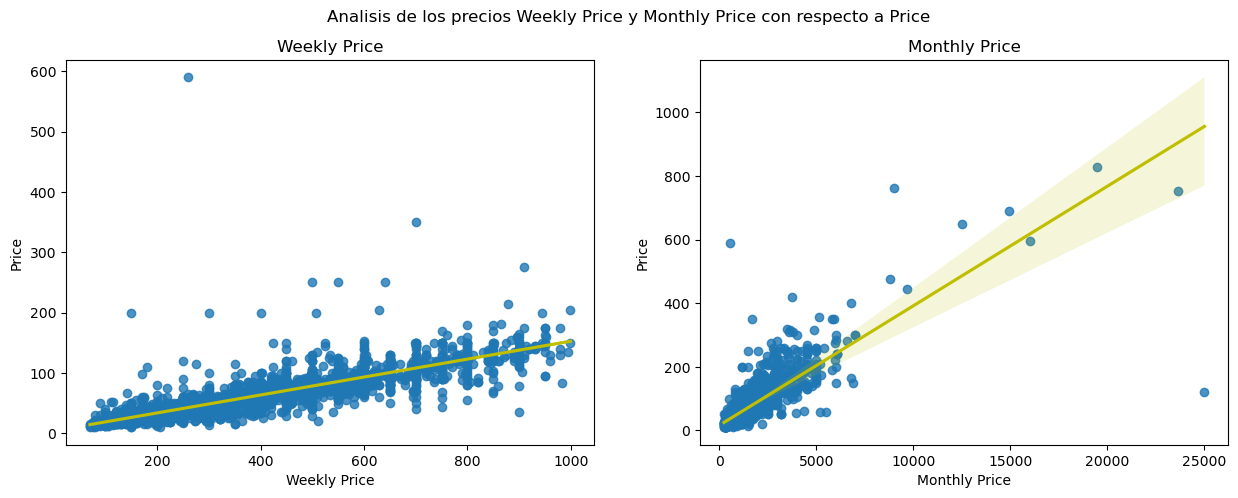

In [299]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Analisis de los precios Weekly Price y Monthly Price con respecto a Price')
sns.regplot(ax=axes[0], data=df_madrid, x='Weekly Price', y='Price', line_kws=dict(color="y"))
axes[0].set_title('Weekly Price')
sns.regplot(ax=axes[1], data=df_madrid, x='Monthly Price', y='Price', line_kws=dict(color="y"))
axes[1].set_title('Monthly Price')

Como podemos ver, tenemos una relación obvia entre las variables, por lo que vamos a descartar 'Weekly Price' y 'Monthly Price' y quedarnos solamente con 'Price'.

In [300]:
rowsToDrop = ['Weekly Price','Monthly Price']
df_madrid = df_madrid.drop(rowsToDrop, axis=1)

La columna 'Price' tiene 17 valores NA que representan el 0.1% del total, y teniendo en cuenta que es la variable objetivo y precisamente el objetivo del modelo es encontrar este precio, las borramos del dataframe

In [301]:
analizar_na_columna(df_madrid,['Price'])
df_madrid = df_madrid.dropna(subset=['Price'])
print('Columna price despues de borrar NA\n')
analizar_na_columna(df_madrid,['Price'])

| Columna   |   Total Filas |   NA |    % NA |   Sin NA |   % Sin NA |
|-----------+---------------+------+---------+----------+------------|
| Price     |         14780 |   17 | 0.11502 |    14763 |     99.885 |


Columna price despues de borrar NA

| Columna   |   Total Filas |   NA |   % NA |   Sin NA |   % Sin NA |
|-----------+---------------+------+--------+----------+------------|
| Price     |         14763 |    0 |      0 |    14763 |        100 |




### 1.4.- Filtrado de inmuebles de Madrid y borrado de algunas columnas relacionadas con localización

Tras analizar detenidamente el dataset, podemos comprobar que la mejor forma de quedarnos con los inmuebles de Madrid es filtrar por la columna City. El problema que nos surge es que en columna city hay valores que corresponde a otros campos, como por ejemplo barrio, e incluso algunos valores que están en chino, pero que mirando el dataset corresponden con barrios de madrid, así que vamos a hacer un filtrado de los datos quedandonos solo con aquellos campos que contengan la cadena "Madrid" (y sus variantes) y cadenas concretas que identiquemos como valores correctos.

##### 1.4.1 Filtrado de NA

La columna City, posee algunos NA. Tras analizar el dataframe, comprobamos que todos los valores corresponden a Madrid, así que convertimos los NA de City en el valor Madrid

In [302]:
analizar_na_columna(df_madrid, ['City'])
print(df_madrid[df_madrid['City'].isna()][['City','Neighbourhood','Neighbourhood Cleansed']].head(6))
df_madrid['City'] = df_madrid['City'].fillna('Madrid')
print('\nTras imputar Madrid a los NA...\n')
analizar_na_columna(df_madrid, ['City'])

| Columna   |   Total Filas |   NA |      % NA |   Sin NA |   % Sin NA |
|-----------+---------------+------+-----------+----------+------------|
| City      |         14763 |    6 | 0.0406421 |    14757 |    99.9594 |


      City Neighbourhood Neighbourhood Cleansed
1279   NaN           NaN   Ciudad Universitaria
5776   NaN           NaN   Ciudad Universitaria
9072   NaN           NaN   Ciudad Universitaria
10878  NaN        Cortes                 Cortes
14196  NaN           NaN   Ciudad Universitaria
14620  NaN      Arapiles           Vallehermoso

Tras imputar Madrid a los NA...

| Columna   |   Total Filas |   NA |   % NA |   Sin NA |   % Sin NA |
|-----------+---------------+------+--------+----------+------------|
| City      |         14763 |    0 |      0 |    14763 |        100 |




##### 1.4.2 Filtrado por City

Analizando el dataset y mirando los valores únicos de la columna 'City', nos quedamos solamente con aquellos valores que nos interesan.

In [303]:
cities_permitidos = ['Madrid', 'madrid','MADRID','Madri','Madrid, Comunidad de Madrid, ES','Madrid, Comunidad de Madrid, ESPANA','Aravaca','Aravaca (Madrid)','Boadilla del Monte','Centro','Centro, Madrid','Chueca','Chueca, Madrid','Comunidad de Madrid','Delicias','Delicias-Madrid','Madrid, Vallecas (Fontarrón)','Motilla del Palancar','Pozuelo','Pozuelo de Alarcón','San Fernando de Henares','Valderrodrigo','Ventas','las matas  madrid','villa verde bajo','馬德里','马德里']
df_madrid = df_madrid[df_madrid['City'].isin(cities_permitidos)]

#### 1.4.3 Borrado de columnas

Ahora que ya solo tenemos inmuebles de Madrid, un total de 13325, eliminanos los datos geográficos que no aportan información relevante. Solo vamos a quedarnos con 2, 'Neighbourhood Cleansed' y 'Neighbourhood Group Cleansed', de cara a evaluar la repercusión de cada uno de ellos en el modelo. Ambos aportan información del barrio, uno mas detallado y otro más agrupado, pero debemos evaluarlos en el modelo.
Zipcode también vamos a borrarlo, ya que tras visualizar el dataset, vemos que existen barrios con más de un 'Zipcode', por lo que no se puede inferir los Zipcodes del resto
Entonces borraremos las colunas de:
- Street
- Neighbourhood
- City
- Zipcode
- State
- Market
- Smart Location
- Country Code
- Country
- Latitude
- Longitude
- Geolocation

In [304]:
rowsToDrop = ['Street','Neighbourhood','City','Zipcode','State','Market','Smart Location','Country Code','Country','Latitude','Longitude','Geolocation']
df_madrid = df_madrid.drop(rowsToDrop, axis=1)

### 1.5.- Código final para la limpieza de datos previa al split

Creamos una función llamada limpieza que reune todo el código anterior, por si es necesario utlizar dicho código posteriormente.

In [305]:
def limpieza(dataframe):
    #Borrado punto 1
    rowsToDrop = ['ID','Listing Url','Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location','Host About', 'Host Response Time', 'Host Response Rate','Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url','Host Neighbourhood', 'Host Listings Count','Host Total Listings Count', 'Host Verifications','Calculated host listings count','Name', 'Summary','Space', 'Description', 'Experiences Offered', 'Neighborhood Overview','Notes', 'Transit', 'Access', 'Interaction', 'House Rules','Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url','Scrape ID', 'Last Scraped','Calendar last Scraped','Features','Calendar Updated']
    dataframe = dataframe.drop(rowsToDrop, axis=1)

    #Borrado punto 2
    rowsToDrop = ['Square Feet','Has Availability','License','Jurisdiction Names']
    dataframe = dataframe.drop(rowsToDrop, axis=1)

    #Borrado punto 3
    rowsToDrop = ['Weekly Price','Monthly Price']
    dataframe = dataframe.drop(rowsToDrop, axis=1)

    #Filtrado punto 4
    cities_permitidos = ['Madrid', 'madrid','MADRID','Madri','Madrid, Comunidad de Madrid, ES','Madrid, Comunidad de Madrid, ESPANA','Aravaca','Aravaca (Madrid)','Boadilla del Monte','Centro','Centro, Madrid','Chueca','Chueca, Madrid','Comunidad de Madrid','Delicias','Delicias-Madrid','Madrid, Vallecas (Fontarrón)','Motilla del Palancar','Pozuelo','Pozuelo de Alarcón','San Fernando de Henares','Valderrodrigo','Ventas','las matas  madrid','villa verde bajo','馬德里','马德里']
    dataframe = dataframe[dataframe['City'].isin(cities_permitidos)]
    rowsToDrop = ['Street','Neighbourhood','City','Zipcode','State','Market','Smart Location','Country Code','Country','Latitude','Longitude','Geolocation']
    dataframe = dataframe.drop(rowsToDrop, axis=1)

    return dataframe

# 2.- Dividimos en train test

In [306]:
train, test = train_test_split(df_madrid, test_size=0.2, shuffle=True, random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('./train.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (10652, 33)
Dimensiones del dataset de test: (2664, 33)


# 3.- Análisis de variables

Una vez realizada la división entre train/test, podemos pasar a analizar las variables sobre las que tenemos dudas

### 3.1.- Security Deposit

| Columna          |   Total Filas |   NA |    % NA |   Sin NA |   % Sin NA |
|------------------+---------------+------+---------+----------+------------|
| Security Deposit |         10652 | 6155 | 57.7826 |     4497 |    42.2174 |




<Axes: xlabel='Security Deposit', ylabel='Price'>

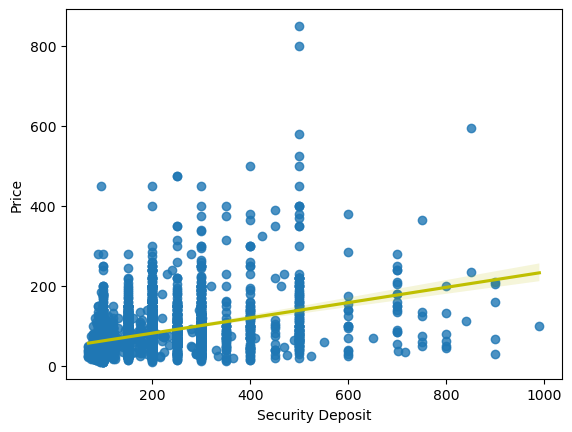

In [307]:
analizar_na_columna(df_train, ['Security Deposit'])
sns.regplot(data=df_train, x='Security Deposit', y='Price', line_kws=dict(color="y"))

Podemos combrobar que esta columna tiene una ligerísima relación con el precio, pero que tiene una gran cantidad de valores nulos. Considero que inferir el valor del 57% de los datos a partur del 42% es un error, así que voy a comprobar dos escenarios: interpretando que los valores nulos son 0, y por otro lado, categorizando este campo como si tiene un valor o no.

##### 3.1.1- Interpretando valor 0

| Columna          |   Total Filas |   NA |   % NA |   Sin NA |   % Sin NA |
|------------------+---------------+------+--------+----------+------------|
| Security Deposit |         10652 |    0 |      0 |    10652 |        100 |


| Columna          |   Total |    Mean |     Std |   Min |   MinOut Total |   MinOut % |   MinOut Value |   Q1 |   Q2 |   Q3 |   MaxOut Value |   MaxOut Total |   MaxOut % |   Max |
|------------------+---------+---------+---------+-------+----------------+------------+----------------+------+------+------+----------------+----------------+------------+-------|
| Security Deposit |   10652 | 77.7694 | 115.438 |     0 |              0 |          0 |           -225 |    0 |    0 |  150 |            375 |            270 |    2.53474 |   990 |


<Axes: xlabel='Security Deposit', ylabel='Price'>

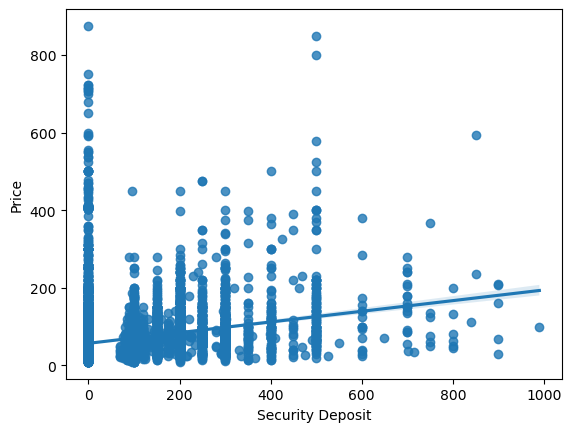

In [308]:
df_train.loc[df_train[df_train['Security Deposit'].isna()].index, 'Security Deposit'] = 0
analizar_na_columna(df_train, ['Security Deposit'])
extended_describe(df_train,['Security Deposit'])
sns.regplot(data=df_train, x='Security Deposit', y='Price')

##### 3.1.1- Interpretando como si o no

Si la columna 'Security Deposit' tiene valor diferente de 0, ponerle 1

| Columna                  |   Total Filas |   NA |   % NA |   Sin NA |   % Sin NA |
|--------------------------+---------------+------+--------+----------+------------|
| Security Deposit Grouped |         10652 |    0 |      0 |    10652 |        100 |


| Columna                  |   Total |     Mean |      Std |   Min |   MinOut Total |   MinOut % |   MinOut Value |   Q1 |   Q2 |   Q3 |   MaxOut Value |   MaxOut Total |   MaxOut % |   Max |
|--------------------------+---------+----------+----------+-------+----------------+------------+----------------+------+------+------+----------------+----------------+------------+-------|
| Security Deposit Grouped |   10652 | 0.422174 | 0.493929 |     0 |              0 |          0 |           -1.5 |    0 |    0 |    1 |            2.5 |              0 |          0 |     1 |


<Axes: xlabel='Security Deposit Grouped', ylabel='Price'>

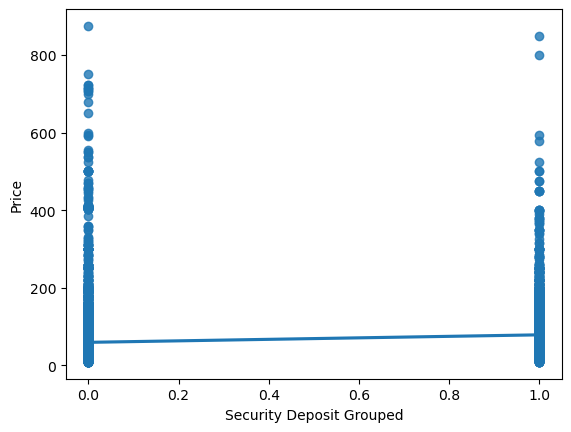

In [309]:
df_train['Security Deposit Grouped'] = df_train['Security Deposit'].apply(lambda x: 1 if x != 0 else 0)
analizar_na_columna(df_train, ['Security Deposit Grouped'])
extended_describe(df_train,['Security Deposit Grouped'])
sns.regplot(data=df_train, x='Security Deposit Grouped', y='Price')

En cualquiera de las dos opciones anteriores, se observa que la relación con el precio o bien no cambia o incluso disminuye.
Como además esta variable es una opción que el host puede poner o no, considero que inferir ese valor sacando media o moda de otras columnas es un error. 
Debido a todo esto, considero que se debe eliminar esta columna.

In [310]:
df_train = df_train.drop(['Security Deposit','Security Deposit Grouped'], axis=1)

### 3.2.- Cleaning Fee

Esta comisión la pone el host a la hora de publicar su inmueble, por lo que vamos a interpretar que si no aparece es que el host no ha querido ponerla. Por lo que vamos a rellenar los NA con 0

| Columna      |   Total Filas |   NA |    % NA |   Sin NA |   % Sin NA |
|--------------+---------------+------+---------+----------+------------|
| Cleaning Fee |         10652 | 4359 | 40.9219 |     6293 |    59.0781 |




<Axes: xlabel='Cleaning Fee', ylabel='Price'>

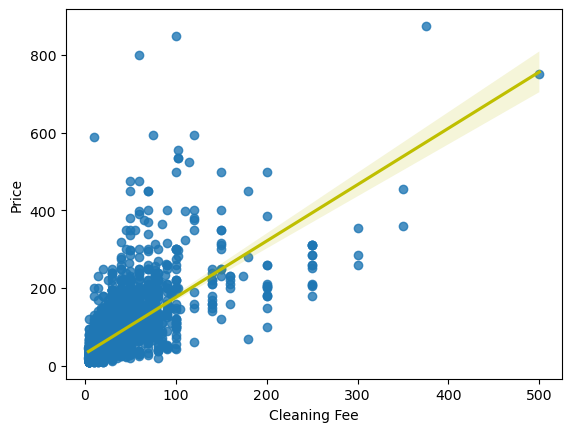

In [311]:
analizar_na_columna(df_train, ['Cleaning Fee'])
sns.regplot(data=df_train, x='Cleaning Fee', y='Price', line_kws=dict(color="y"))

Convertimos NA en 0

| Columna      |   Total Filas |   NA |   % NA |   Sin NA |   % Sin NA |
|--------------+---------------+------+--------+----------+------------|
| Cleaning Fee |         10652 |    0 |      0 |    10652 |        100 |




<Axes: xlabel='Cleaning Fee', ylabel='Price'>

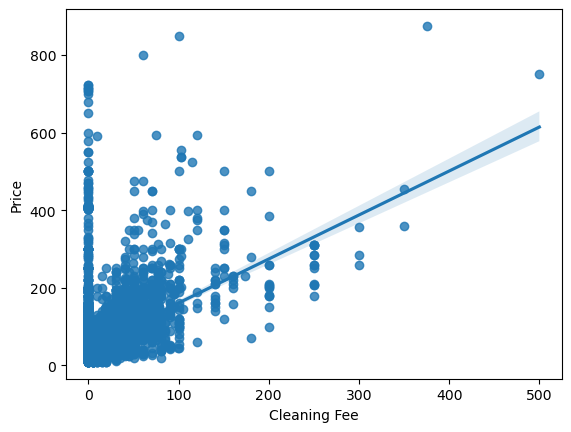

In [312]:
df_train.loc[df_train[df_train['Cleaning Fee'].isna()].index, 'Cleaning Fee'] = 0
analizar_na_columna(df_train, ['Cleaning Fee'])

sns.regplot(data=df_train, x='Cleaning Fee', y='Price')

Una vez eliminados los valores nulos, analicemos los posibles outliers. Siguiendo con los valores que habitualmente nos daría un boxplot, nos encontramos que tenemos alrededor de 260 outliers. Obviamente no todos los valores van a ser outliers, porque existen otras variables como el tiempo de estancia(no es lo mismo la limpieza de una noche que de una semana, de una persona que de 5, de una casa que de un apartamento...), por lo que vamos a analizar aquellos valores que destacan sobre el resto, por ejemplo aquellos valores cuyo 'Cleaning Fee' sea mayor a 350. 
'

In [313]:
extended_describe(df_train, ['Cleaning Fee'])
df_train[df_train['Cleaning Fee'] >= 350].head().T

| Columna      |   Total |    Mean |     Std |   Min |   MinOut Total |   MinOut % |   MinOut Value |   Q1 |   Q2 |   Q3 |   MaxOut Value |   MaxOut Total |   MaxOut % |   Max |
|--------------+---------+---------+---------+-------+----------------+------------+----------------+------+------+------+----------------+----------------+------------+-------|
| Cleaning Fee |   10652 | 17.5587 | 24.9621 |     0 |              0 |          0 |            -45 |    0 |   10 |   30 |             75 |            260 |    2.44086 |   500 |


,4789,5778,7383,10260
Neighbourhood Cleansed,Nueva España,Castellana,Nueva España,Ciudad Universitaria
Neighbourhood Group Cleansed,Chamartín,Salamanca,Chamartín,Moncloa - Aravaca
Property Type,Apartment,Apartment,House,House
Room Type,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
Accommodates,7,7,10,14
Bathrooms,3.5,3.0,5.0,6.0
Bedrooms,4.0,4.0,5.0,7.0
Beds,5.0,6.0,9.0,9.0
Bed Type,Real Bed,Real Bed,Real Bed,Real Bed
Amenities,"TV,Cable TV,Internet,Wireless Internet,Air con...","TV,Cable TV,Internet,Wireless Internet,Air con...","TV,Cable TV,Internet,Wireless Internet,Air con...","TV,Wireless Internet,Air conditioning,Pool,Kit..."


De esta información sacamos que no hay realmente outliers, porque parece que el elevado importe de Cleaning Fee está justificado. Casas grandes con muchas estancias o bien apartamentos que a priori, por estar en barrios céntricos y con un precio por noche elevado, pueden ser de más alta calidad que otros inmuebles.

En conclusión, esta columna se queda en el estado actual.

### 3.3.- Availability

A priori, podriamos llegar a interpretar que una disponibilidad pequeña, en cualquiera de sus márgenes temporales, podría tener impacto en el precio, en mayor o menor medida. Vamos a estudiar la relación de cada una de las variables con el precio.

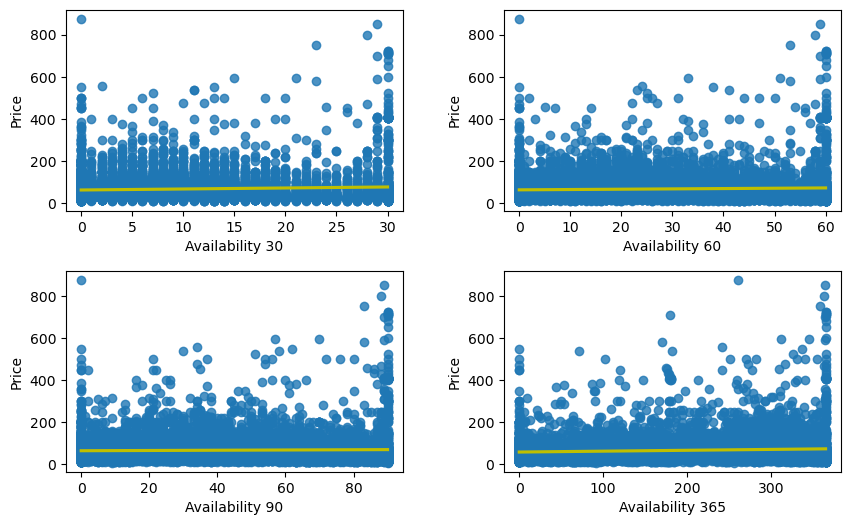

In [314]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
sns.regplot(x='Availability 30', y='Price', data=df_train, ax=axes[0, 0], line_kws=dict(color="y"))
sns.regplot(x='Availability 60', y='Price', data=df_train, ax=axes[0, 1], line_kws=dict(color="y"))
sns.regplot(x='Availability 90', y='Price', data=df_train, ax=axes[1, 0], line_kws=dict(color="y"))
sns.regplot(x='Availability 365', y='Price', data=df_train, ax=axes[1, 1], line_kws=dict(color="y"))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

Al contrario de lo que pensabamos antes, observamos que no hay ninguna relación entre disponibilidad y precio. Revisemos también la correlación entre los márgenes temporales

<Axes: >

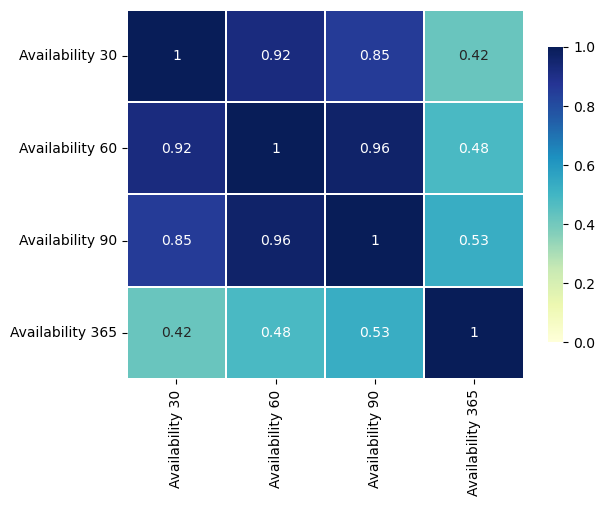

In [315]:
corr = df_train[['Availability 30','Availability 60','Availability 90','Availability 365']].corr()
sns.heatmap(corr, annot=True,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

Al considerar que no hay relación entre las variables y precio, y como parece que hay una correlación mínima de un 42% entre las variables, consideramos sacarlas.

In [316]:
rowsToDrop = ['Availability 30','Availability 60','Availability 90','Availability 365']
df_train = df_train.drop(rowsToDrop, axis=1)

### 3.4.- Minimun nights y maximun nights

Estas dos variables, aparentemente, no parecen tener una relación clara con el precio. De todas formás vamos a mirar su relación con el precio para estimar mantenerlas o borrarlas

Text(0.5, 1.0, 'Maximum Nights')

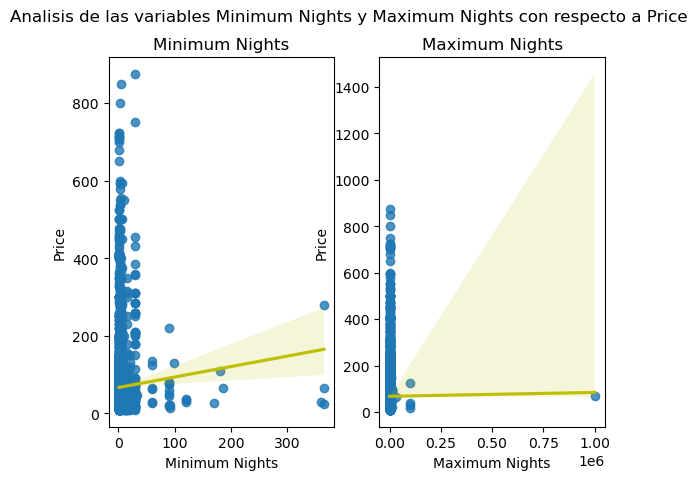

In [317]:
#Hacemos un grafico en seaborn para poner dos graficos dentro, que relacionen las variables de minimun nights y maximun nights con el precio
fig, axes = plt.subplots(1, 2)
fig.suptitle('Analisis de las variables Minimum Nights y Maximum Nights con respecto a Price')
sns.regplot(ax=axes[0], data=df_train, x='Minimum Nights', y='Price', line_kws=dict(color="y"))
axes[0].set_title('Minimum Nights')
sns.regplot(ax=axes[1], data=df_train, x='Maximum Nights', y='Price', line_kws=dict(color="y"))
axes[1].set_title('Maximum Nights')


Analicemos también los NA que tienen las dos columnas

In [318]:
analizar_na_columna(df_train, ['Minimum Nights','Maximum Nights'])

| Columna        |   Total Filas |   NA |   % NA |   Sin NA |   % Sin NA |
|----------------+---------------+------+--------+----------+------------|
| Minimum Nights |         10652 |    0 |      0 |    10652 |        100 |
| Maximum Nights |         10652 |    0 |      0 |    10652 |        100 |




Aunque no poseen valores nulos, la relación con el precio de estas dos variables es casi nula(de hecho, en el caso de la variable 'Maximun nights' es practicamente nula), por lo que procederemos a borrarlas.

In [319]:
rowsToDrop = ['Minimum Nights','Maximum Nights']
df_train = df_train.drop(rowsToDrop, axis=1)

### 3.5.- Reviews

El dataframe posee varios campos de valoraciones, para cada muchas de las características. De un primer vistazo, tiene sentido que todas las variables estén muy relacionadas entre si, porque generalmente las valoraciones buenas en el aspecto general conllevan valoraciones buenas en los aspectos individuales. De todas formas, vamos a mirar las relaciones entre todas las columnas de valoraciones para comprobarlo.

##### 3.5.1- Campos de fechas

Los campos con información sobre la primera y la última Review no aportan información, así que los borramos.

In [320]:
rowsToDrop = ['First Review','Last Review']
df_train = df_train.drop(rowsToDrop, axis=1)

##### 3.5.2- Correlacion entre variables

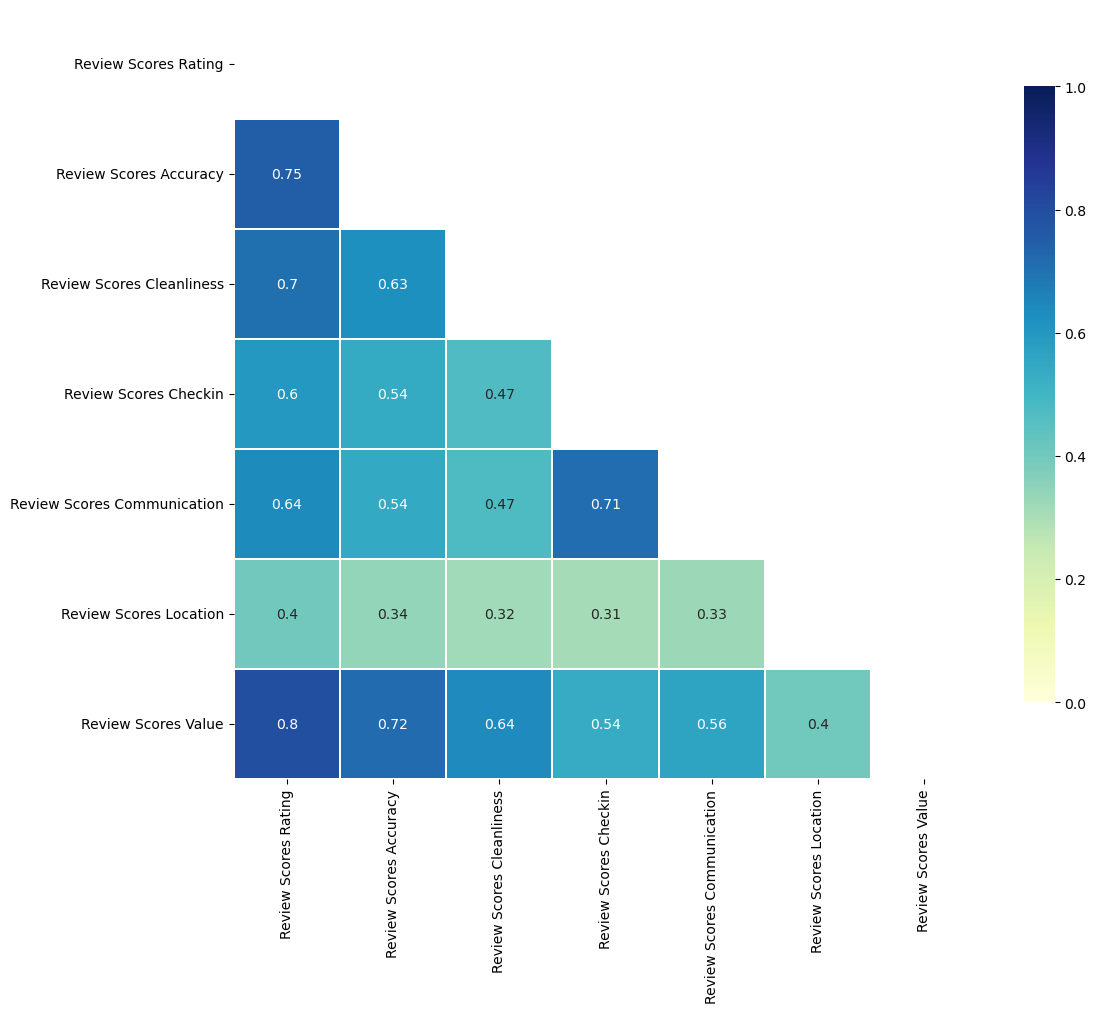

Correlacion entre las variables de review scores
                             Review Scores Rating  Review Scores Accuracy  \
Review Scores Rating                     1.000000                0.748348   
Review Scores Accuracy                   0.748348                1.000000   
Review Scores Cleanliness                0.703891                0.625614   
Review Scores Checkin                    0.598907                0.540042   
Review Scores Communication              0.639059                0.544534   
Review Scores Location                   0.399347                0.339954   
Review Scores Value                      0.795570                0.718650   

                             Review Scores Cleanliness  Review Scores Checkin  \
Review Scores Rating                          0.703891               0.598907   
Review Scores Accuracy                        0.625614               0.540042   
Review Scores Cleanliness                     1.000000               0.471362   
Review Sco

In [321]:
corr = df_train[['Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value']].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8},annot=True)
plt.show()
print('Correlacion entre las variables de review scores')
print(corr)

Como podemos comprobar, la columna Review Scores Rating tiene una alta correlación con todas las variables, excepto con la de ubicación, que no tiene correlación muy alta con ninguna otra. Por esto mismo, nos quedaremos con esas dos columnas. 

In [322]:
rowsToDrop = ['Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Value']
df_train = df_train.drop(rowsToDrop, axis=1)

La columna reviews per month tampoco aporta información relevante, por lo que la quitamos

In [323]:
rowsToDrop = ['Reviews per Month']
df_train = df_train.drop(rowsToDrop, axis=1)

##### 3.5.3- Análisis de NA

Ahora trataremos los NA.Como podemos observar tenemos NA en ambas columnas.

In [324]:
analizar_na_columna(df_train, ['Review Scores Rating','Review Scores Location'])

| Columna                |   Total Filas |   NA |    % NA |   Sin NA |   % Sin NA |
|------------------------+---------------+------+---------+----------+------------|
| Review Scores Rating   |         10652 | 2320 | 21.7799 |     8332 |    78.2201 |
| Review Scores Location |         10652 | 2339 | 21.9583 |     8313 |    78.0417 |




Vamos a inferir los valores faltantes de la media de cada barrio para cada columna. Es decir, para la columna Review Scores Rating, sacamos la media de cada barrio y la ponemos en vez del NA

In [325]:
df_train['Review Scores Rating'] = df_train['Review Scores Rating'].fillna(df_train.groupby('Neighbourhood Cleansed')['Review Scores Rating'].transform('mean'))
df_train['Review Scores Location'] = df_train['Review Scores Location'].fillna(df_train.groupby('Neighbourhood Cleansed')['Review Scores Location'].transform('mean'))
analizar_na_columna(df_train, ['Review Scores Rating','Review Scores Location'])

| Columna                |   Total Filas |   NA |      % NA |   Sin NA |   % Sin NA |
|------------------------+---------------+------+-----------+----------+------------|
| Review Scores Rating   |         10652 |    4 | 0.0375516 |    10648 |    99.9624 |
| Review Scores Location |         10652 |    4 | 0.0375516 |    10648 |    99.9624 |




Existe un barrio concreto, que es Fuentelareina, que solo tiene 4 inmuebles y ninguno tiene valores en esas dos columnas, por lo cual no se pueden inferir ningún tipo de valor. A estos 4 registros les pondremos valor 0

In [326]:
df_train.loc[df_train[df_train['Neighbourhood Cleansed'] == 'Fuentelareina'].index, 'Review Scores Rating'] = 0
df_train.loc[df_train[df_train['Neighbourhood Cleansed'] == 'Fuentelareina'].index, 'Review Scores Location'] = 0
analizar_na_columna(df_train, ['Review Scores Rating','Review Scores Location'])

| Columna                |   Total Filas |   NA |   % NA |   Sin NA |   % Sin NA |
|------------------------+---------------+------+--------+----------+------------|
| Review Scores Rating   |         10652 |    0 |      0 |    10652 |        100 |
| Review Scores Location |         10652 |    0 |      0 |    10652 |        100 |




Y ahora si están a 0

Y hasta aquí el análisis de variables dudosas. A partir de este punto ya nos queda trabajar con columnas que sabemos que poseen valores que nos interesan.

# 4.- Categorización de columnas

Convertirmos las columnas categoricas de texto, en numéricas

In [327]:
categorical = ['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'Property Type','Room Type','Bed Type','Cancellation Policy']

mean_map = {}
for c in categorical:
    mean = df_train.groupby(c)['Price'].mean()
    df_train[c] = df_train[c].map(mean)    
    mean_map[c] = mean

# 5.- Amenities

Para los amenities, vamos a contar cuantos exiten en cada inmueble, y crearemos una columna nueva con el total de amenities, que es la que pasaremos al modelo.

In [328]:
#PAra quitar NA, ponemos los NA como una cadena vacia
df_train['Amenities'] = df_train['Amenities'].fillna('')
#en la columna amenities, vamos a contar cuantos elementos hay en cada fila, y lo guardamos en una nueva columna llamada amenities_count
df_train['amenities_count'] = df_train['Amenities'].apply(lambda x: len(x.split(',')))
#borramos la columna amenities
df_train = df_train.drop(['Amenities'], axis=1)


# 6.- Ultimo borrado de NA

Miramos ahora filas quedan con NA en el dataframe

In [329]:
columnas = df_train.columns.tolist()
analizar_na_columna(df_train, columnas)

| Columna                      |   Total Filas |   NA |     % NA |   Sin NA |   % Sin NA |
|------------------------------+---------------+------+----------+----------+------------|
| Neighbourhood Cleansed       |         10652 |    0 | 0        |    10652 |   100      |
| Neighbourhood Group Cleansed |         10652 |    0 | 0        |    10652 |   100      |
| Property Type                |         10652 |    0 | 0        |    10652 |   100      |
| Room Type                    |         10652 |    0 | 0        |    10652 |   100      |
| Accommodates                 |         10652 |    0 | 0        |    10652 |   100      |
| Bathrooms                    |         10652 |   40 | 0.375516 |    10612 |    99.6245 |
| Bedrooms                     |         10652 |   19 | 0.17837  |    10633 |    99.8216 |
| Beds                         |         10652 |   38 | 0.356741 |    10614 |    99.6433 |
| Bed Type                     |         10652 |    0 | 0        |    10652 |   100      |

Vemos que nos quedan algunas filas con NA en las columnas de Bathrooms, Bedrooms y Beds, pero como supone, en el peor de los casos, menos de un 1% del total, procedemos a borrar esas filas

In [330]:
df_train = df_train.dropna()

# 7.- Probar modelos

Preparamos el pipeline que resume todas las instrucciones que hemos aplicado al dataframe de train, para poder aplicarlo posteriomente al test y a cualquier dato nuevo que entre al modelo.

In [331]:
def pipeline(df):
    df = df.drop(['Security Deposit'], axis=1)
    df = df.drop(['Availability 30','Availability 60','Availability 90','Availability 365'], axis=1)
    df = df.drop(['Minimum Nights','Maximum Nights'], axis=1)
    df = df.drop(['First Review','Last Review'], axis=1) 
    df = df.drop(['Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Value'],axis=1)
    df = df.drop(['Reviews per Month'], axis=1)

    categorical = ['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'Property Type','Room Type','Bed Type','Cancellation Policy']
    mean_map = {}
    for c in categorical:
        mean = df.groupby(c)['Price'].mean()
        df[c] = df[c].map(mean)    
        mean_map[c] = mean
    
    df['Amenities'] = df['Amenities'].fillna('')
    df['amenities_count'] = df['Amenities'].apply(lambda x: len(x.split(',')))
    df = df.drop(['Amenities'], axis=1)
    df= df.dropna()

    return df

Preparamos X e Y tanto para train como para test, y escalamos para tener los valores correctos de cara a probar los diferentes modelos.

In [332]:
y_train = df_train['Price'].values
X_train = df_train.drop(['Price'], axis=1).values
feature_names = df_train.drop(['Price'], axis=1).columns

In [333]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')
df_test = pipeline(df_test)
y_test = df_test['Price'].values
X_test = df_test.drop(['Price'], axis=1).values


In [334]:
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_Scaled = scaler.transform(X_train)
X_test_Scaled = scaler.transform(X_test)

##### Regresión polinómica

Comenzamos con el modelo más básico, la regresión polinómica. 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................polynomialfeatures__degree=1; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=1; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=1; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=1; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=1; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=2; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=2; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=2; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=2; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=2; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=3; total time=   0.5s
[CV] END .......................polynomialfeature

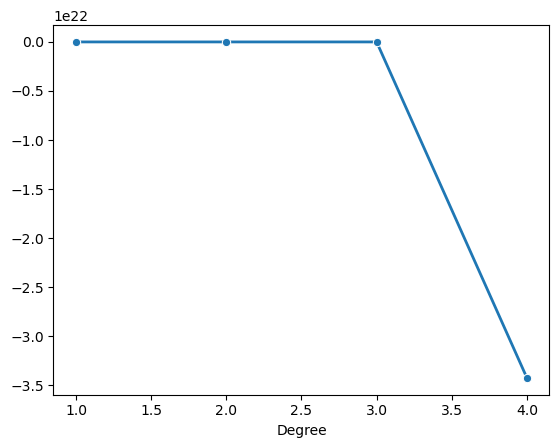

In [335]:
model = make_pipeline(PolynomialFeatures(), LinearRegression())
degrees = [1, 2, 3, 4]
param_grid = {'polynomialfeatures__degree': degrees}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error',verbose=2)
grid.fit(X_train_Scaled, y_train)
print("Mejores parámetros:", grid.best_params_)
print("Mejor score:", grid.best_score_)

scores = np.array(grid.cv_results_['mean_test_score'])
sns.lineplot(x=degrees,y=scores,marker="o",linewidth=2)
plt.xlabel("Degree")
plt.show()

In [336]:
poly= PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_Scaled)
X_test_poly = poly.fit_transform(X_test_Scaled)

model = LinearRegression()
model.fit(X_train_poly, y_train)
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

print(f'MSE train: {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE test: {mean_squared_error(y_test, y_test_pred)}')

print(f'RMSE train: {np.sqrt(mean_squared_error(y_train, y_train_pred))}')
print(f'RMSE test: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')



MSE train: 1599.7318002505986
MSE test: 815.6544080339344
RMSE train: 39.99664736263026
RMSE test: 28.559664004219908


Text(0.5, 1.0, 'Residuos')

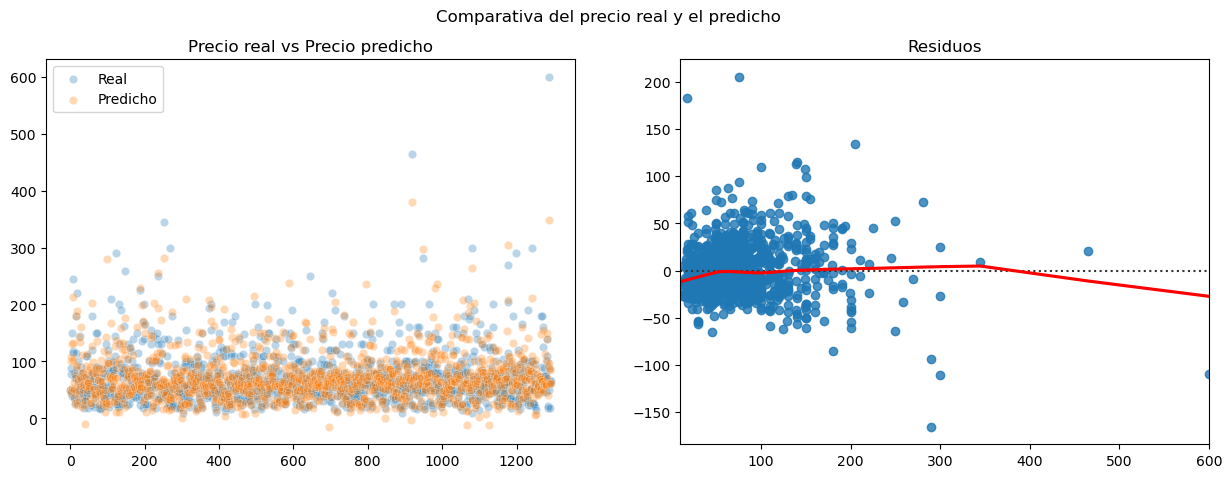

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Comparativa del precio real y el predicho')
sns.scatterplot(ax=axes[0],data=y_test, alpha=0.3)
sns.scatterplot(ax=axes[0],data=y_test_pred, alpha=0.3)
axes[0].legend(['Real', 'Predicho'])
axes[0].set_title('Precio real vs Precio predicho')
sns.residplot(ax=axes[1],x=y_test, y=y_test_pred, lowess=True, line_kws=dict(color="r"))
axes[1].set_title('Residuos')




Podemos comprobar que el modelo no es bueno, porque aunque los valores salen con una distribución similar a tanto en train como en test, tenemos mucha varianza en los residuos. Por ejemplo, vemos que para valores inferiores a 100 euros, puede haber una variación de de 50 euros arriba o abajo en el precio. 

#####  Lasso

best mean cross-validation score: -2161.194
best parameters: {'alpha': 0.018420699693267144}


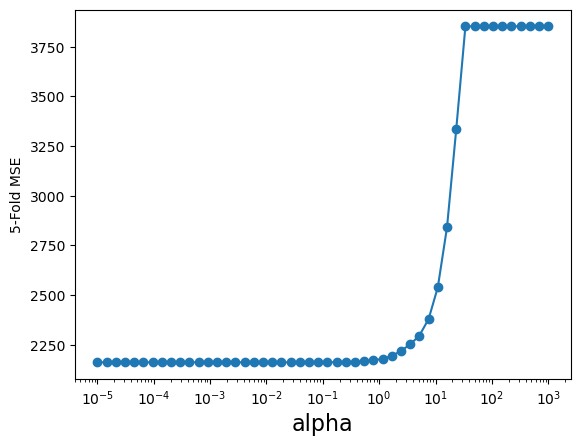

In [338]:
alpha_vector = np.logspace(-5,3,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(X_train_Scaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()


In [339]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train_Scaled,y_train)

y_train_pred = lasso.predict(X_train_Scaled)
y_test_pred = lasso.predict(X_test_Scaled)


print(f'MSE train: {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE test: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE train: {np.sqrt(mean_squared_error(y_train, y_train_pred))}')
print(f'RMSE test: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')
print(f'Lasso Train Score: {lasso.score(X_train_Scaled, y_train)}')
print(f'Lasso Test Score: {lasso.score(X_test_Scaled, y_test)}')
print('---------------\nVariables seleccionadas por Lasso\n---------------')
w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)


MSE train: 2140.1289645265233
MSE test: 897.1439932324128
RMSE train: 46.26152790955486
RMSE test: 29.952362064324955
Lasso Train Score: 0.444423489128589
Lasso Test Score: 0.594828333889433
---------------
Variables seleccionadas por Lasso
---------------
Neighbourhood Cleansed 15.362796091697739
Neighbourhood Group Cleansed -0.6280199106449621
Property Type 0.12002456003926885
Room Type 8.92940990977704
Accommodates 13.853088241386219
Bathrooms 6.753414768941765
Bedrooms 10.672371583653705
Beds -1.696897909158329
Bed Type 0.6809059383458107
Cleaning Fee 12.92098828821965
Guests Included 1.211692151324752
Extra People -4.136928852660484
Number of Reviews -3.9553263932582245
Review Scores Rating 4.3760021708124
Review Scores Location -2.387150182872525
Cancellation Policy -1.7338326587009554
amenities_count -3.707147249199617


Este modelo da muy malos resultados, ya que como podemos ver el score es más alto para test que para train. 

Text(0.5, 1.0, 'Residuos')

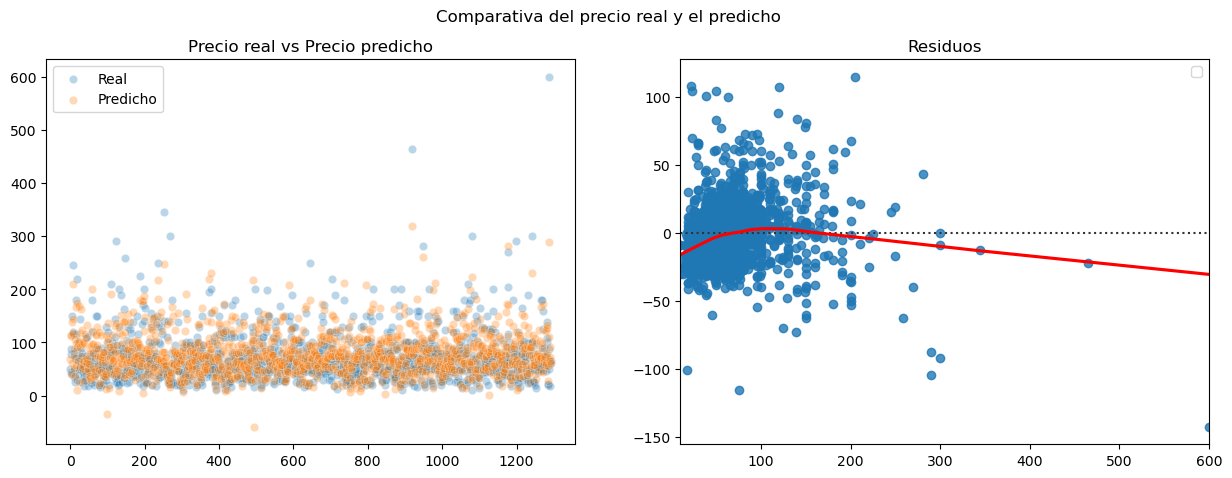

In [340]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Comparativa del precio real y el predicho')
sns.scatterplot(ax=axes[0],data=y_test, alpha=0.3)
sns.scatterplot(ax=axes[0],data=y_test_pred, alpha=0.3)
axes[0].legend(['Real', 'Predicho'])
plt.legend(['Real', 'Predicho'])
axes[0].set_title('Precio real vs Precio predicho')
sns.residplot(ax=axes[1],x=y_test, y=y_test_pred, lowess=True, line_kws=dict(color="r"))
axes[1].set_title('Residuos')

Y en las gráficas tenemos el mismo problema que en la regresión lineal, que tenemos mucho diferencia en los residuos. Se pueden ver diferencias de más de 100 euros para precios muy pequeños.
Además el modelo tampoco consigue reducir las variables usadas, es decir, no pone ninguna a 0.

##### Ridge

best mean cross-validation score: -2168.209
best parameters: {'alpha': 79.06043210907734}


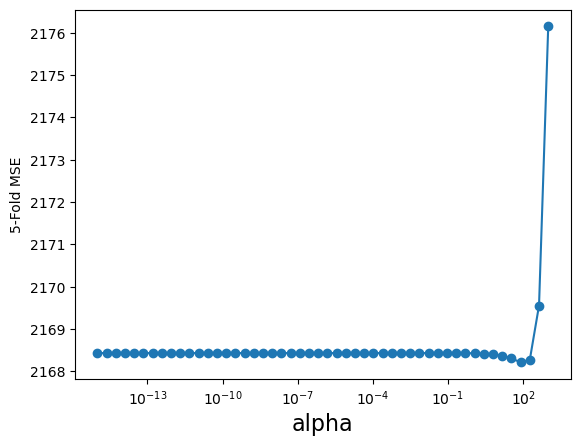

In [341]:
alpha_vector = np.logspace(-15,3,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(X_train_Scaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [342]:
alpha_optimo = grid.best_params_['alpha']
ridge = Ridge(alpha = alpha_optimo).fit(X_train_Scaled,y_train)

y_train_pred = ridge.predict(X_train_Scaled)
y_test_pred = ridge.predict(X_test_Scaled)

print(f'MSE train: {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE test: {mean_squared_error(y_test, y_test_pred)}')

print(f'RMSE train: {np.sqrt(mean_squared_error(y_train, y_train_pred))}')
print(f'RMSE test: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')
print(f'Ridge Train Score: {ridge.score(X_train_Scaled, y_train)}')
print(f'Ridge Test Score: {ridge.score(X_test_Scaled, y_test)}')
print('---------------\nVariables seleccionadas por Ridge\n---------------')
w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE train: 2140.201426633041
MSE test: 894.284702892423
RMSE train: 46.26231108184113
RMSE test: 29.90459334103079
Ridge Train Score: 0.4444046779985231
Ridge Test Score: 0.5961196577345311
---------------
Variables seleccionadas por Ridge
---------------
Neighbourhood Cleansed 15.362796091697739
Neighbourhood Group Cleansed -0.6280199106449621
Property Type 0.12002456003926885
Room Type 8.92940990977704
Accommodates 13.853088241386219
Bathrooms 6.753414768941765
Bedrooms 10.672371583653705
Beds -1.696897909158329
Bed Type 0.6809059383458107
Cleaning Fee 12.92098828821965
Guests Included 1.211692151324752
Extra People -4.136928852660484
Number of Reviews -3.9553263932582245
Review Scores Rating 4.3760021708124
Review Scores Location -2.387150182872525
Cancellation Policy -1.7338326587009554
amenities_count -3.707147249199617


Text(0.5, 1.0, 'Residuos')

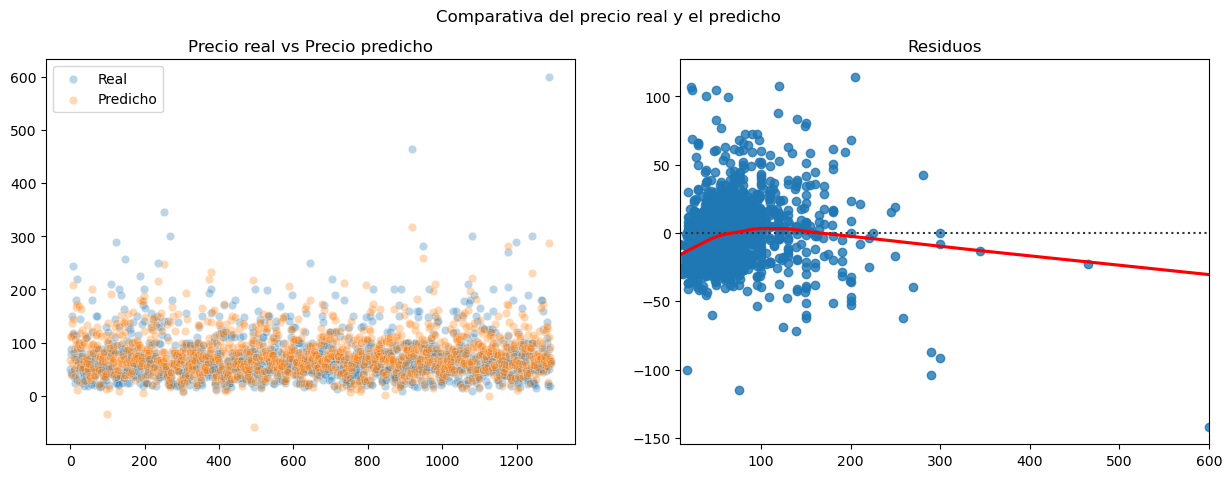

In [343]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Comparativa del precio real y el predicho')
sns.scatterplot(ax=axes[0],data=y_test, alpha=0.3)
sns.scatterplot(ax=axes[0],data=y_test_pred, alpha=0.3)
axes[0].legend(['Real', 'Predicho'])
axes[0].set_title('Precio real vs Precio predicho')
sns.residplot(ax=axes[1],x=y_test, y=y_test_pred, lowess=True, line_kws=dict(color="r"))
axes[1].set_title('Residuos')

Seguimos con los mismos problemas que en la regresión lineal y Lasso. Este modelo tampoco nos vale.

##### 7.4 Random Forest

Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=1; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=3; total time=   0.4s
[CV] END ........................................max_depth=3; total time=   0.4s
[CV] END ........................................max_depth=3; total time=   0.4s
[CV] END ........................................max_depth=4; total time=   0.5s
[CV] END ........................................max_depth=4; total time=   0.5s
[CV] END .......................................

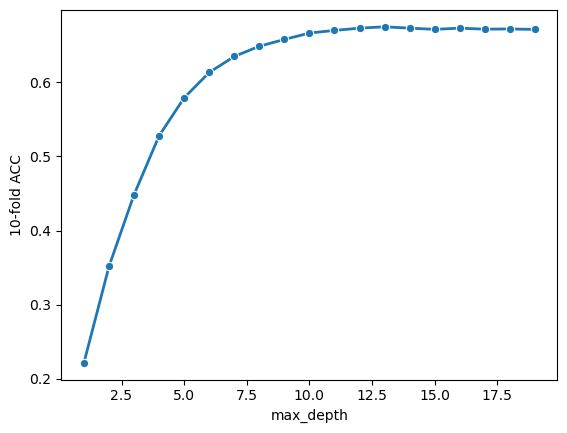

In [344]:
maxDepth = range(1,20)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=param_grid,cv=3, verbose=2) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
sns.lineplot(x=maxDepth,y=scores,marker="o",linewidth=2)
plt.xlabel("max_depth")
plt.ylabel("10-fold ACC")
plt.show()

Consideramos que el mejor valor de profundidad coincide con el seleccionado por GridSearch, en este caso el 13. Aplicamos ese valor al random forest y miramos resultados.

In [345]:
maxDepthOptimo = grid.best_params_['max_depth']
randomForest = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

y_train_pred = randomForest.predict(X_train)
y_test_pred = randomForest.predict(X_test)

print(f'MSE train: {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE test: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE train: {np.sqrt(mean_squared_error(y_train, y_train_pred))}')
print(f'RMSE test: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')
print("Score Train: ",randomForest.score(X_train,y_train))
print("Score Test: ",randomForest.score(X_test,y_test))

MSE train: 419.0572446926652
MSE test: 554.4263994524342
RMSE train: 20.47088773582292
RMSE test: 23.546260838027642
Score Train:  0.8912129288838225
Score Test:  0.749607789054626


Entendemos que el modelo tiene Overfitting, por lo que intentamos aplicar un modelo más simple. Vamos a mirar los resultados en valores entre 7 y 13

In [346]:
data = []
for depth in range(5,20):
    randomForest = RandomForestRegressor(max_depth=depth,n_estimators=200,max_features='sqrt').fit(X_train,y_train)
    data.append([depth,
                 randomForest.score(X_train,y_train),
                 randomForest.score(X_test,y_test),
                 mean_squared_error(y_train, randomForest.predict(X_train)),
                 mean_squared_error(y_test, randomForest.predict(X_test)),
                 np.sqrt(mean_squared_error(y_train, randomForest.predict(X_train))),
                 np.sqrt(mean_squared_error(y_test, randomForest.predict(X_test)))])
print(tabulate(data, headers=['Depth','Train Score','Test Score','MSE Train','MSE Test','RMSE Train','RMSE Test'], tablefmt='orgtbl'))

|   Depth |   Train Score |   Test Score |   MSE Train |   MSE Test |   RMSE Train |   RMSE Test |
|---------+---------------+--------------+-------------+------------+--------------+-------------|
|       5 |      0.627101 |     0.690342 |    1436.44  |    685.654 |      37.9004 |     26.185  |
|       6 |      0.674197 |     0.713566 |    1255.02  |    634.231 |      35.4263 |     25.1839 |
|       7 |      0.722059 |     0.725668 |    1070.65  |    607.435 |      32.7208 |     24.6462 |
|       8 |      0.759925 |     0.730994 |     924.789 |    595.641 |      30.4103 |     24.4058 |
|       9 |      0.795157 |     0.74186  |     789.074 |    571.581 |      28.0905 |     23.9078 |
|      10 |      0.826195 |     0.74189  |     669.511 |    571.515 |      25.8749 |     23.9064 |
|      11 |      0.851877 |     0.742174 |     570.584 |    570.886 |      23.8869 |     23.8932 |
|      12 |      0.873167 |     0.746926 |     488.573 |    560.364 |      22.1037 |     23.672  |
|      13 

Tras revisar los scores tanto como para train como para test para las profundidades entre 5 y 20, encontramos que el parámetro que mejor se ajusta a ambos es la profundidad de 7, que da unos valores muy parecidos tanto para train como para test.
Más allá de 7, se incrementa mucho el score para train, pero el score para test se queda parado en 0.74

# Conclusión

El modelo más eficiente de los probados es Random Forest con un valor de profundidad máxima de 7. Es el modelo que más se ajusta a los datos para train y para test(aproximadamente un 72%), aunque no es un modelo con un rendimiento espectacular.

Para los datos, entendemos que los datos llegan ya filtrados con la limpieza previa(borrado de columnas innecesarias, solo valores de Madrid). Solo tendremos que tratar el resto de columnas. Dejamos a continuación el pipeline creado para esa limpieza de columnas

In [347]:
def pipeline(df):
    df = df.drop(['Security Deposit'], axis=1)
    df = df.drop(['Availability 30','Availability 60','Availability 90','Availability 365'], axis=1)
    df = df.drop(['Minimum Nights','Maximum Nights'], axis=1)
    df = df.drop(['First Review','Last Review'], axis=1) 
    df = df.drop(['Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Value'],axis=1)
    df = df.drop(['Reviews per Month'], axis=1)

    categorical = ['Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'Property Type','Room Type','Bed Type','Cancellation Policy']
    mean_map = {}
    for c in categorical:
        mean = df.groupby(c)['Price'].mean()
        df[c] = df[c].map(mean)    
        mean_map[c] = mean
    
    df['Amenities'] = df['Amenities'].fillna('')
    df['amenities_count'] = df['Amenities'].apply(lambda x: len(x.split(',')))
    df = df.drop(['Amenities'], axis=1)
    df= df.dropna()
    return df

Este código viene de analizar las columnas después de separar en train/test